# Two-particle bosonic-fermionic quantum walk
We provide an implementation of the two-particle quantum walk. The aim is to reproduce the results of "Two-particle bosonic-fermionic quantum walk via integrated photonics" by L. Sansoni et al. [[1]] with Perceval.

[1]: https://arxiv.org/pdf/1106.5713.pdf

In [1]:
# imports
import matplotlib.pyplot as plt

import numpy as np

import perceval as pcvl
from perceval.components.unitary_components import BS
from perceval.backends import SLOSBackend
from perceval.simulators import Simulator
from perceval.components import Source

## Use the symbolic skin for display
from perceval.rendering import DisplayConfig, SymbSkin
DisplayConfig.select_skin(SymbSkin)

## Building an array of beam splitters 
The dynamics of a quantum walk can be achieved by an array of beam splitters (BSs) as in figure. Here we reproduce a four steps quantum walk, we highlight the difference between the optical spatial modes (in red) and the walk positions (in blue).

<img src="../_static/img/quantum_walk_pretty.png" alt= "Quantum walk" height="500">

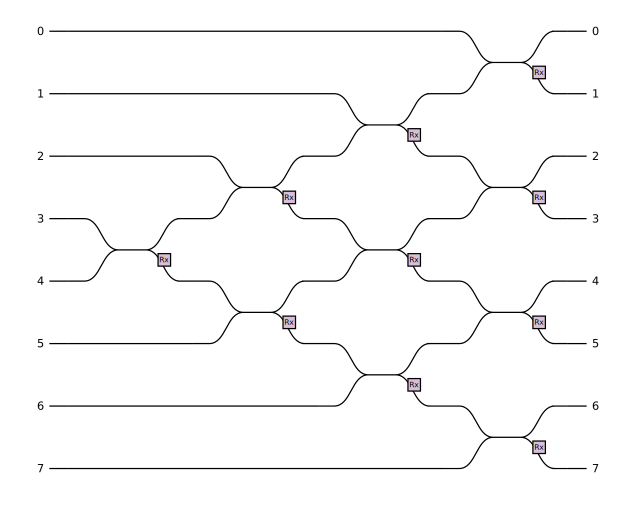

In [2]:
# number of steps
steps = 4
# spatial modes are twice the number of steps
n = 2*steps

# BS_array contains the input modes of the BSs at each step
BS_array = [[[0]*2]*(i+1) for i in range(steps)]

i_0 = n/2
for s in range(steps):
    if s==0:
        BS_array[s][0] = [i_0, i_0-1]
    else:
        z = 0
        for i, j in BS_array[s-1]:
            if [i+1, i] not in BS_array[s]:
                BS_array[s][z] = [i+1, i]
                z += 1
            if [j, j-1] not in BS_array[s]:
                BS_array[s][z] = [j, j-1]
                z += 1

# build the circuit
circuit = pcvl.Circuit(n)
for s in range(steps):
    for bs in BS_array[s]:
        circuit.add(int(bs[1]), BS())

# display the circuit
pcvl.pdisplay(circuit)

## Single photon quantum walk
We can check the functioning of the BSs array as a quantum walk simulator putting a single photon in the first input position (mode 3 <-> walk position 0) of the array. Then we can check the output probability distribution of the photon in the corresponding walk positions.

In [3]:
# define input state by inserting a photon in the first mode
mode = 3
in_list = [0]*n
in_list[mode] = 1
in_state = pcvl.BasicState(in_list)

# select a backend and define the simulator on the circuit
simulator = Simulator(SLOSBackend())
simulator.set_circuit(circuit)

#Define a source and input distribution due to source noise
source = Source(losses=0, indistinguishability=1)
input_distribution = source.generate_distribution(expected_input=in_state)

prob_dist = simulator.probs_svd(input_distribution)
print("output distribution:", prob_dist["results"])


output distribution: {
	|0,0,1,0,0,0,0,0>: 0.0625
	|1,0,0,0,0,0,0,0>: 0.0625
	|0,1,0,0,0,0,0,0>: 0.0625
	|0,0,0,0,0,1,0,0>: 0.5625000000000001
	|0,0,0,1,0,0,0,0>: 0.0625
	|0,0,0,0,1,0,0,0>: 0.0625
	|0,0,0,0,0,0,0,1>: 0.0625
	|0,0,0,0,0,0,1,0>: 0.0625
}


From the corresponding states of the distribution we have direct access to the output modes. What we want though, is to check the output probability distribution of the photon in the corresponding walk positions. From the initial figure we can define the mapping mode -> walk position. Then, we just have to take care of taking the modes probability distribution and and, for each walk position, sum the probabilities of the corresponding modes.

In [4]:
# function that takes a state and returns the modes of the photons
def get_mode(state):
    modes = [i for i, x in enumerate(state) if x >= 1]
    return modes if len(modes) > 1 else modes[0]
# dictionary to map the mode to the position
mode_to_walk_pos_mapping = {
    0: 4,
    1: 2,
    2: 2,
    3: 0,
    4: 0,
    5: -2,
    6: -2,
    7: -4
}

In [5]:
for state in prob_dist["results"].keys():
    print(state)

|0,0,1,0,0,0,0,0>
|1,0,0,0,0,0,0,0>
|0,1,0,0,0,0,0,0>
|0,0,0,0,0,1,0,0>
|0,0,0,1,0,0,0,0>
|0,0,0,0,1,0,0,0>
|0,0,0,0,0,0,0,1>
|0,0,0,0,0,0,1,0>


In [6]:
# get output modes from the distribution
modes_probs = [(get_mode(state), prob) for state, prob in prob_dist["results"].items()]

modes_probs = sorted(modes_probs, key=lambda x: x[0])

# print modes and probabilities
for mode, prob in modes_probs:
    print("Mode: {}, Probability: {}".format(mode, prob))

Mode: 0, Probability: 0.0625
Mode: 1, Probability: 0.0625
Mode: 2, Probability: 0.0625
Mode: 3, Probability: 0.0625
Mode: 4, Probability: 0.0625
Mode: 5, Probability: 0.5625000000000001
Mode: 6, Probability: 0.0625
Mode: 7, Probability: 0.0625


Walk position: -4, Probability: 0.0625
Walk position: -3, Probability: 0
Walk position: -2, Probability: 0.6250000000000001
Walk position: -1, Probability: 0
Walk position: 0, Probability: 0.125
Walk position: 1, Probability: 0
Walk position: 2, Probability: 0.125
Walk position: 3, Probability: 0
Walk position: 4, Probability: 0.0625


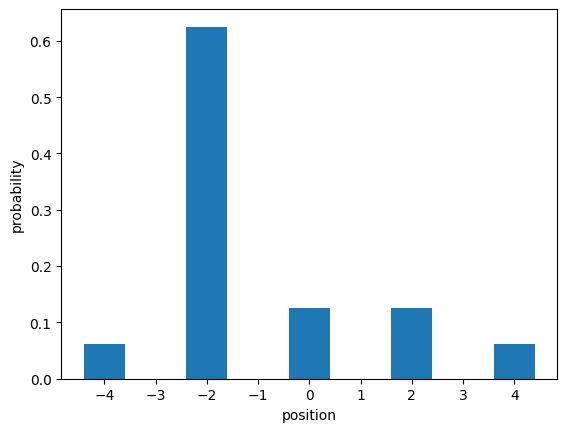

In [7]:
# get the walk positions distribution
walk_pos = range(-steps, steps+1)
walk_probs = [0]*(2*steps+1)


for i, w_p in enumerate(walk_pos):
    idxs = [index for (index, (mode, prob)) in enumerate(modes_probs) if mode_to_walk_pos_mapping[mode] == w_p]
    if len(idxs) > 0:
        walk_probs[i] = sum([modes_probs[idx][1] for idx in idxs])
    else:
        walk_probs[i] = 0

# print walk positions and probabilities
for w_p, w_p_p in zip(walk_pos, walk_probs):
    print("Walk position: {}, Probability: {}".format(w_p, w_p_p))

# plot the walk positions distribution
plt.bar(walk_pos, walk_probs)
plt.xticks(walk_pos)
plt.xlabel("position")
plt.ylabel("probability")
plt.show()

## Two photons quantum walk
Now we can follow the same procedure as before, but with two input photons in the two input modes (3 and 4).

In [8]:
# two photons input state
in_list = [0]*n
in_list[3], in_list[4] = 1, 1
in_state = pcvl.BasicState(in_list)

# select a backend and define the simulator on the circuit
simulator = Simulator(SLOSBackend())
simulator.set_circuit(circuit)

# define a source and input distribution due to source noise
source = Source(losses=0, indistinguishability=1)
input_distribution = source.generate_distribution(expected_input=in_state)

prob_dist = simulator.probs_svd(input_distribution)
print("output distribution:", prob_dist["results"])

output distribution: {
	|1,0,1,0,0,0,0,0>: 0.0625
	|0,0,0,1,0,1,0,0>: 0.0625
	|2,0,0,0,0,0,0,0>: 0.0078125
	|0,0,0,1,0,0,1,0>: 0.015625
	|1,0,0,0,1,0,0,0>: 0.015625
	|0,0,0,0,0,1,1,0>: 0.0625
	|1,1,0,0,0,0,0,0>: 0.015625
	|1,0,0,0,0,1,0,0>: 0.015625000000000007
	|0,1,0,0,1,0,0,0>: 0.015625
	|0,0,1,1,0,0,0,0>: 0.015625000000000007
	|0,2,0,0,0,0,0,0>: 0.0078125
	|0,0,0,0,0,0,1,1>: 0.015625
	|0,1,1,0,0,0,0,0>: 0.0625
	|0,1,0,0,0,1,0,0>: 0.015625000000000007
	|0,0,2,0,0,0,0,0>: 0.07031250000000001
	|0,0,1,0,1,0,0,0>: 0.0625
	|0,0,0,0,0,1,0,1>: 0.0625
	|0,0,1,0,0,1,0,0>: 0.2500000000000001
	|0,0,1,0,0,0,1,0>: 0.015625000000000007
	|0,0,1,0,0,0,0,1>: 0.015625000000000007
	|0,0,0,2,0,0,0,0>: 0.0078125
	|0,0,0,1,0,0,0,1>: 0.015625
	|0,0,0,0,2,0,0,0>: 0.0078125
	|0,0,0,0,1,1,0,0>: 0.015625000000000007
	|0,0,0,0,0,2,0,0>: 0.07031250000000001
	|0,0,0,0,0,0,2,0>: 0.0078125
	|0,0,0,0,0,0,0,2>: 0.0078125
}


In [9]:
# get output modes from the distribution
modes = [get_mode(state) for state in prob_dist["results"].keys()]
## take care of the case where there is only one mode
modes = [m if isinstance(m, list) else [m,m] for m in modes]

# get the probabilities of the modes
probs = np.array([[0]*n]*n, dtype=np.float64)

for m, prob in zip(modes, prob_dist["results"].values()):
    probs[m[0], m[1]] = prob

In [10]:
# get the walk positions distribution
walk_pos = range(-steps, steps+1)

walk_probs = np.array([[0]*(2*steps+1)]*(2*steps+1), dtype=np.float64)
for i in range(n):
    for j in range(n):
        w_i = mode_to_walk_pos_mapping[i]+steps
        w_j = mode_to_walk_pos_mapping[j]+steps
        walk_probs[w_i, w_j] += probs[i,j]

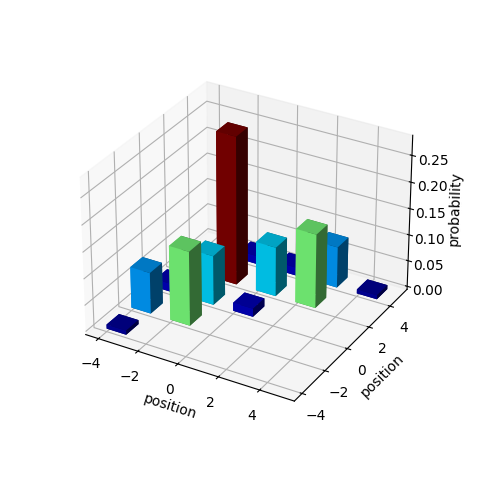

In [11]:
# plot as 3dbar
x, y = np.meshgrid(walk_pos, walk_pos)
cmap = plt.get_cmap('jet') # Get desired colormap
max_height = np.max(walk_probs.flatten())  
min_height = np.min(walk_probs.flatten())
# scale each z to [0,1], and get their rgb values
rgba = [cmap((k-min_height)/max_height) if k!=0 else (0,0,0,0) for k in walk_probs.flatten()] 
fig = plt.figure(figsize=(6, 8))
ax = fig.add_subplot(111, projection='3d')
ax.bar3d(x.flatten(), y.flatten(), np.zeros((2*steps+1)*(2*steps+1)), 1, 1, walk_probs.flatten(), color=rgba)
ax.set_xlabel("position")
ax.set_ylabel("position")
ax.set_zlabel("probability")
ax.set_box_aspect(aspect=None, zoom=0.8)
plt.show()

### Bosonic-fermionic quantum walks
Moreover, we can select an entangled state as the input state and observe that the output distribution behaves differently with respect to the state statistic.

In [12]:
# two entangled input states
bosonic_state = pcvl.StateVector("|0,0,0,{1},{2},0,0,0>") + pcvl.StateVector("|0,0,0,{2},{1},0,0,0>")
fermionic_state = pcvl.StateVector("|0,0,0,{1},{2},0,0,0>") - pcvl.StateVector("|0,0,0,{2},{1},0,0,0>")


# select a backend and define the simulator on the circuit
simulator = Simulator(SLOSBackend())
simulator.set_circuit(circuit)

bosonic_prob_dist = simulator.probs(bosonic_state)
fermionic_prob_dist = simulator.probs(fermionic_state)

print("bosonic output distribution:", bosonic_prob_dist)
print("fermionic output distribution:", fermionic_prob_dist)

bosonic output distribution: {
	|1,0,0,0,1,0,0,0>: 0.015624999999999997
	|0,0,0,1,0,0,1,0>: 0.015624999999999997
	|0,0,0,0,0,1,1,0>: 0.06250000000000001
	|1,1,0,0,0,0,0,0>: 0.015624999999999997
	|0,0,1,0,0,0,0,1>: 0.015625000000000003
	|0,0,1,0,0,1,0,0>: 0.25000000000000006
	|0,0,0,0,0,1,0,1>: 0.06250000000000001
	|0,1,1,0,0,0,0,0>: 0.06250000000000001
	|0,0,0,0,0,0,1,1>: 0.015624999999999997
	|0,0,0,1,0,1,0,0>: 0.06250000000000001
	|2,0,0,0,0,0,0,0>: 0.007812499999999998
	|0,0,0,0,0,0,2,0>: 0.007812499999999998
	|0,0,0,1,0,0,0,1>: 0.015624999999999997
	|0,0,0,0,0,0,0,2>: 0.007812499999999998
	|0,1,0,0,1,0,0,0>: 0.015624999999999997
	|1,0,0,0,0,1,0,0>: 0.015625000000000003
	|0,0,1,0,1,0,0,0>: 0.06250000000000001
	|1,0,1,0,0,0,0,0>: 0.06250000000000001
	|0,0,0,0,2,0,0,0>: 0.007812499999999998
	|0,0,1,1,0,0,0,0>: 0.015625000000000003
	|0,2,0,0,0,0,0,0>: 0.007812499999999998
	|0,0,0,0,1,1,0,0>: 0.015625000000000003
	|0,0,2,0,0,0,0,0>: 0.07031250000000001
	|0,0,1,0,0,0,1,0>: 0.015625000000

In [13]:
# get output modes from the distributions
bosonic_modes = [get_mode(state) for state, _ in bosonic_prob_dist.items()]
bosonic_modes = [m if isinstance(m, list) else [m,m] for m in bosonic_modes]
fermionic_modes = [get_mode(state) for state, _ in fermionic_prob_dist.items()]
fermionic_modes = [m if isinstance(m, list) else [m,m] for m in fermionic_modes]

# get the probabilities of the modes
bosonic_probs = np.array([[0]*n]*n, dtype=np.float64)
for m, (_, prob) in zip(bosonic_modes, bosonic_prob_dist.items()):
    bosonic_probs[m[0], m[1]] = prob

fermionic_probs = np.array([[0]*n]*n, dtype=np.float64)
for m, (_, prob) in zip(fermionic_modes, fermionic_prob_dist.items()):
    fermionic_probs[m[0], m[1]] = prob

# get the walk positions distributions
walk_pos = range(-steps, steps+1)

bosonic_walk_probs = np.array([[0]*(2*steps+1)]*(2*steps+1), dtype=np.float64)
fermionic_walk_probs = np.array([[0]*(2*steps+1)]*(2*steps+1), dtype=np.float64)
for i in range(n):
    for j in range(n):
        w_i = mode_to_walk_pos_mapping[i]+steps
        w_j = mode_to_walk_pos_mapping[j]+steps
        bosonic_walk_probs[w_i, w_j] += bosonic_probs[i,j]
        fermionic_walk_probs[w_i, w_j] += fermionic_probs[i,j]

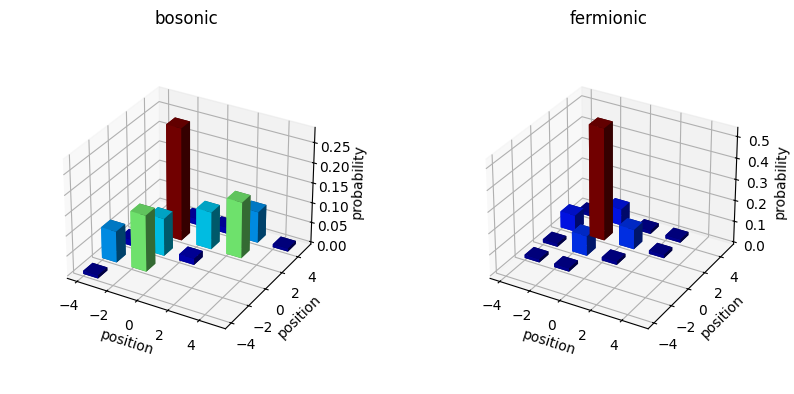

In [14]:
# plot the two distributions as 3dbar subplots
x, y = np.meshgrid(walk_pos, walk_pos)
cmap = plt.get_cmap('jet') # Get desired colormap
bosonic_max_height = np.max(bosonic_walk_probs.flatten())
bosonic_min_height = np.min(bosonic_walk_probs.flatten())
fermionic_max_height = np.max(fermionic_walk_probs.flatten())
fermionic_min_height = np.min(fermionic_walk_probs.flatten())
# scale each z to [0,1], and get their rgb values
bosonic_rgba = [cmap((k-bosonic_min_height)/bosonic_max_height) if k!=0 else (0,0,0,0) for k in bosonic_walk_probs.flatten()]
fermionic_rgba =  [cmap((k-fermionic_min_height)/fermionic_max_height) if k!=0 else (0,0,0,0) for k in fermionic_walk_probs.flatten()]
fig = plt.figure(figsize=(10, 16))
ax = plt.subplot(1, 2, 1, projection='3d')
ax.bar3d(x.flatten(), y.flatten(), np.zeros((2*steps+1)*(2*steps+1)), 1, 1, bosonic_walk_probs.flatten(), color=bosonic_rgba)
ax.set_xlabel("position")
ax.set_ylabel("position")
ax.set_zlabel("probability")
ax.set_box_aspect(aspect=None, zoom=0.8)
ax.set_title("bosonic")
ax = plt.subplot(1, 2, 2, projection='3d')
ax.bar3d(x.flatten(), y.flatten(), np.zeros((2*steps+1)*(2*steps+1)), 1, 1, fermionic_walk_probs.flatten(), color=fermionic_rgba)
ax.set_xlabel("position")
ax.set_ylabel("position")
ax.set_zlabel("probability")
ax.set_box_aspect(aspect=None, zoom=0.8)
ax.set_title("fermionic")
plt.show()